In [1]:
import os
import fnmatch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def read_all_rotations(dirname, filebase):
    '''Read results from dirname from files matching filebase'''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(dirname), filebase)
    files.sort()
    results = []
    
    # Loop over matching files
    for f in files:
        fp = open("%s/%s"%(dirname,f), "rb")
        r = pickle.load(fp)
        fp.close()
        results.append(r)
    return results

# Part 1
- Implement a network with hidden layer sizes as follows: 400, 200, 100, 50, 25, 12
- Do not add regularization
- Execute a 2-dimensional experiment: rotation x training set size (just as we did in HW 1). Use training set sizes: 1,2,3,5,9,13,18
- Write code that aggregates the results together (in fact, you should be use your code from HW 1).
- FIGURE 1: Generate a plot that shows FVAF as a function of training set size. There should be two curves: mean FVAF for each of training and validation sets. Don't forget to label your axes and to provide a legend.

In [3]:
filebase = "noreg_ddtheta_hidden_400_200_100_50_25_12_JI_Ntraining_*_rotation_*_results.pkl"
results = read_all_rotations("results/noreg", filebase)

In [4]:
print(len(results)) # should be 20*7 = 140 eventually
results[0].keys()

140


dict_keys(['args', 'predict_training', 'predict_training_eval', 'outs_training', 'time_training', 'predict_validation', 'predict_validation_eval', 'outs_validation', 'time_validation', 'predict_testing', 'predict_testing_eval', 'outs_testing', 'time_testing', 'folds', 'history', 'fname_base'])

In [5]:
# what args did we use?
results[0]['args']

Namespace(dataset='/home/fagg/datasets/bmi/bmi_dataset2.pkl', output_type='ddtheta', predict_dim=None, Nfolds=20, activation_out=None, activation_hidden='swish', hidden=[400, 200, 100, 50, 25, 12], rotation=0, epochs=1000, Ntraining=13, exp_type='noreg', exp_index=100, lrate=0.001, dropout=None, L1_regularization=None, L2_regularization=None, min_delta=0.0, patience=100, gpu=False, cpus_per_task=10, results_path='./results', verbose=0, nogo=False, check=False)

In [6]:
results[0]['history'].keys()

dict_keys(['loss', 'fvaf', 'root_mean_squared_error', 'val_loss', 'val_fvaf', 'val_root_mean_squared_error'])

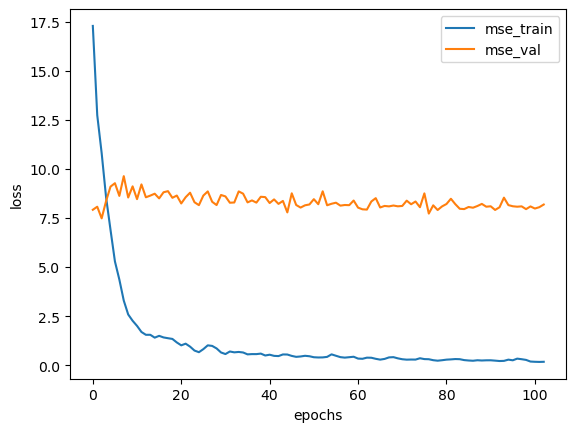

In [7]:
# plot learning curve
plt.figure()
plt.plot(results[0]['history']['loss'], label='mse_train')
plt.plot(results[0]['history']['val_loss'], label='mse_val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [8]:
# Nfolds = 20 = # of rotations
# Ntraining = training set size = 1,2,3,5,9,13,18
results_array = np.nan * np.ones([20,18,3]) # (rotations x training set sizes)
for i in range(len(results)):
    r = results[i]['folds']['folds_training'][0]
    tss = results[i]['folds']['folds_training'].size - 1
    results_array[r,tss,0] = np.sum(results[i]['predict_training_eval'][1])/2 # we wnat the average fvaf
    results_array[r,tss,1] = np.sum(results[i]['predict_validation_eval'][1])/2 # fvaf is index 1
    results_array[r,tss,2] = np.sum(results[i]['predict_testing_eval'][1])/2 # fvaf is length 2, so sum and divide by 2
results_array_noreg = np.delete(results_array, [3,5,6,7,9,10,11,13,14,15,16], axis=1) # delete unused columns

In [9]:
mean_noreg = np.sum(results_array_noreg,0)/20 # FVAF average across rotations

In [10]:
tss_plot_x = [1,2,3,5,9,13,18] # list of folds (for plotting)
results_plot_y = mean_noreg
print(results_plot_y)

[[0.97246295 0.63903005 0.63029295]
 [0.97608316 0.66716318 0.6551138 ]
 [0.97768335 0.68133567 0.67053824]
 [0.93374613 0.69392286 0.67991583]
 [0.96759086 0.710578   0.69654878]
 [0.90193796 0.71886114 0.70594535]
 [0.85611775 0.73177029 0.71908093]]


### FIGURE 1

In [11]:
mean_noreg_test = mean_noreg[:,2]

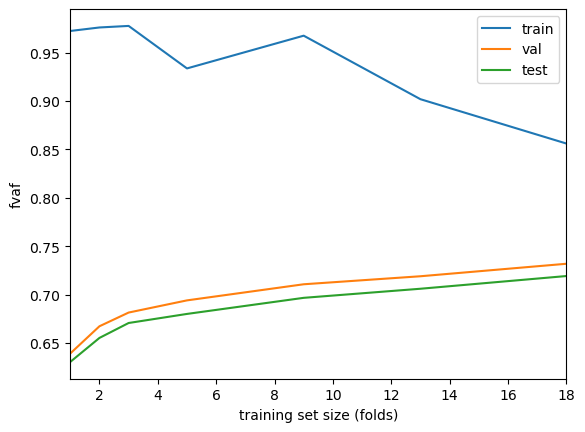

In [12]:
plt.figure()
plt.plot(tss_plot_x, results_plot_y[:,0], label='train')
plt.plot(tss_plot_x, results_plot_y[:,1], label='val')
plt.plot(tss_plot_x, results_plot_y[:,2], label='test')
plt.ylabel('fvaf')
plt.xlabel('training set size (folds)')
plt.xlim([1,18])
plt.legend()

# Part 2
- Implement the same network as above.
- Add dropout to your Input layer and each of your Hidden layers. There should be no other regularization.
- Execute a 3-dimensional experiment: rotation x training set size x dropout rate. Attempt a reasonable range of dropout probabilities (use at least 4 choices). Probability of dropout should be between 0 and 1 (non-inclusive).
- Write code that aggregates the results together.
- FIGURE 2: Show mean FVAF for the validation set as a function of training set size. There should be one curve for each of your dropout probability choices.
- Don't forget to label your axes and to provide a legend

In [13]:
filebase = "dropout_ddtheta_hidden_400_200_100_50_25_12_JI_dropout_*_Ntraining_*_rotation_*_results.pkl"
results = read_all_rotations("results/dropout", filebase)

In [14]:
print(len(results)) # should be 20*7*5 = 700 eventually

700


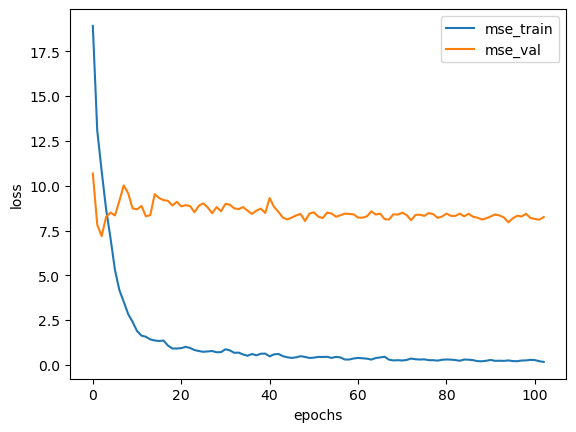

In [15]:
# plot learning curve
plt.figure()
plt.plot(results[0]['history']['loss'], label='mse_train')
plt.plot(results[0]['history']['val_loss'], label='mse_val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [16]:
# Nfolds = 20 = # of rotations
# largest training set size = max(Ntraining = 1,2,3,5,9,13,18)
# number of dropout rate choices = 5
# train, test, valid = 3
results_array = np.nan * np.ones([20,18,5,3]) # (rotations x training set sizes x dropout rate)
for i in range(len(results)):
    r = results[i]['folds']['folds_training'][0]
    tss = results[i]['folds']['folds_training'].size - 1
    d = int(i / 140)
    results_array[r,tss,d,0] = np.sum(results[i]['predict_training_eval'][1])/2 # we wnat the average fvaf
    results_array[r,tss,d,1] = np.sum(results[i]['predict_validation_eval'][1])/2 # fvaf is index 1
    results_array[r,tss,d,2] = np.sum(results[i]['predict_testing_eval'][1])/2 # fvaf is length 2, so sum and divide by 2
results_array_dropout = np.delete(results_array, [3,5,6,7,9,10,11,13,14,15,16], axis=1) # delete unused columns

In [17]:
mean_dropout = np.sum(results_array_dropout,axis=0)/20 # FVAF average across rotations

In [18]:
tss_plot_x = [1,2,3,5,9,13,18] # list of folds (for plotting)
results_plot_y = mean_dropout[:,:,1] # just valid
print(results_plot_y)

[[0.64065157 0.63937203 0.640718   0.64130963 0.63949762]
 [0.66793481 0.66401293 0.66671056 0.66419854 0.66557393]
 [0.67813235 0.68189654 0.68047671 0.68068001 0.67917743]
 [0.6940439  0.69757113 0.69511384 0.69562852 0.69583848]
 [0.71126891 0.70901706 0.70718872 0.70834594 0.70881744]
 [0.72022269 0.72010233 0.71982159 0.72144796 0.72212866]
 [0.72845421 0.72559423 0.72783695 0.72961319 0.7295946 ]]


### FIGURE 2

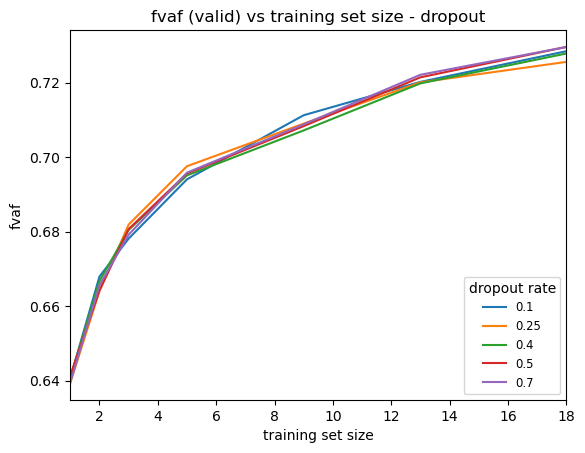

In [19]:
plt.figure()
plt.plot(tss_plot_x, results_plot_y, label=['0.1','0.25','0.4','0.5','0.7'])
plt.ylabel('fvaf')
plt.xlabel('training set size')
plt.title('fvaf (valid) vs training set size - dropout')
plt.xlim([1,18])
plt.legend(title="dropout rate", loc=4, fontsize='small')

# Part 3: Lx Regularization
- Perform the same form of experiment as part 2, except choose a range of values for either L1 or L2 regularization.
- Choose at least four different regularization parameters (factors of 10 are good choices). Do not include dropout.
- FIGURE 3: Create a similar plot as above.

In [20]:
filebase = "lpreg_ddtheta_hidden_400_200_100_50_25_12_JI_l1_*_Ntraining_*_rotation_*_results.pkl"
results = read_all_rotations("results/lpreg", filebase)

In [21]:
print(len(results)) # should be 20*7*5 = 700 eventually

700


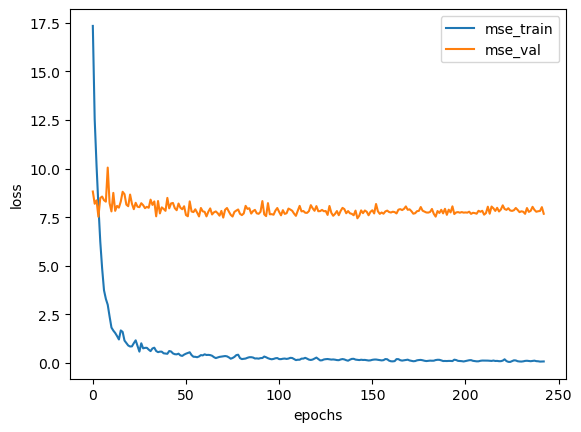

In [22]:
# plot learning curve
plt.figure()
plt.plot(results[0]['history']['loss'], label='mse_train')
plt.plot(results[0]['history']['val_loss'], label='mse_val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [23]:
# Nfolds = 20 = # of rotations
# largest training set size = max(Ntraining = 1,2,3,5,9,13,18)
# number of l1 reg choices = 5
# train, test, valid = 3
results_array = np.nan * np.ones([20,18,5,3]) # (rotations x training set sizes x l1 reg parameter)
for i in range(len(results)):
    r = results[i]['folds']['folds_training'][0]
    tss = results[i]['folds']['folds_training'].size - 1
    d = int(i / 140)
    results_array[r,tss,d,0] = np.sum(results[i]['predict_training_eval'][1])/2 # we wnat the average fvaf
    results_array[r,tss,d,1] = np.sum(results[i]['predict_validation_eval'][1])/2 # fvaf is index 1
    results_array[r,tss,d,2] = np.sum(results[i]['predict_testing_eval'][1])/2 # fvaf is length 2, so sum and divide by 2
results_array_lpreg = np.delete(results_array, [3,5,6,7,9,10,11,13,14,15,16], axis=1) # delete unused columns

In [24]:
mean_lpreg = np.sum(results_array_lpreg,axis=0)/20 # FVAF average across rotations

In [25]:
tss_plot_x = [1,2,3,5,9,13,18] # list of folds (for plotting)
results_plot_y = mean_lpreg[:,:,1] # just valid
print(results_plot_y)

[[0.63805618 0.63829393 0.63864336 0.6394357  0.64052417]
 [0.66495989 0.66658392 0.66581131 0.66481485 0.66414376]
 [0.67998171 0.68068874 0.68219244 0.67673371 0.67955849]
 [0.6971031  0.69521557 0.69373338 0.69397453 0.69487093]
 [0.7089213  0.70928131 0.70788775 0.71099389 0.70988067]
 [0.72005431 0.7194005  0.72092415 0.71902622 0.71966331]
 [0.72831142 0.72884163 0.72776728 0.72521774 0.72809557]]


### FIGURE 3

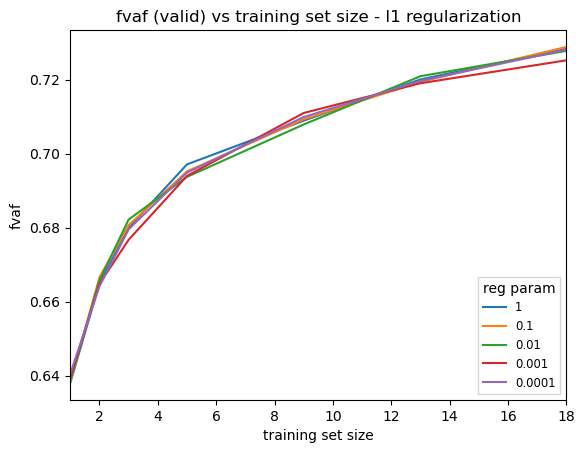

In [26]:
plt.figure()
plt.plot(tss_plot_x, results_plot_y, label=['1','0.1','0.01','0.001','0.0001'])
plt.ylabel('fvaf')
plt.xlabel('training set size')
plt.title('fvaf (valid) vs training set size - l1 regularization')
plt.xlim([1,18])
plt.legend(title="reg param", loc=4, fontsize='small', fancybox=False)

# Part 4: Bake-Off
The three parts above correspond to three different model forms that we would like to compare.
- For both sets of 3D runs (part 2 and part 3), you have already computed mean FVAF across the rotations. The result for each part is a matrix indexed by hyper-parameter value and training set size.
- For each of the two parts (Dropout and Lx): for each training set size, identify the hyper-parameter value that maximizes validation performance. The result is that each training set size will have one "best" hyper-parameter value with respect to the mean validation performance.
- For each of the two parts and training set size, for the best hyper-parameter set extract the mean test set performance. This will be a vectors that is indexed by training set size.
- FIGURE 4: Plot the mean test set performance (FVAF) as a function of training set size for each of parts 1, 2 and 3. Note that there is exactly one curve for each part.
- Using the distribution of test set performance measures, perform three T-Tests for each pair of model types for training set size 1 (there will be N=20 samples for each model type; the model types are no regularization, Dropout and Lx). Report the corresponding p-values and the differences in means.
- Perform three T-Tests for each pair of model types for training set size 18. Report the corresponding p-values and the differences in means.

In [27]:
print(mean_noreg_test)

[0.63029295 0.6551138  0.67053824 0.67991583 0.69654878 0.70594535
 0.71908093]


In [28]:
best_index_dropout = np.argmax(mean_dropout[:,:,1],axis=1) # find index of max of each row (best dropout/reg for each tss)

mean_dropout_test = np.zeros(7)
for i, n in enumerate(best_index_dropout):
    mean_dropout_test[i] = mean_dropout[:,:,2][i,n]

print(mean_dropout_test)

[0.6265862  0.6609938  0.66873099 0.6824048  0.69643306 0.70675723
 0.71843174]


In [29]:
best_index_lpreg = np.argmax(mean_lpreg[:,:,1],axis=1)

mean_lpreg_test = np.zeros(7)
for i, n in enumerate(best_index_lpreg):
    mean_lpreg_test[i] = mean_lpreg[:,:,2][i,n]
    
print(mean_lpreg_test)

[0.63209705 0.65607714 0.66780594 0.68566838 0.70136812 0.70317126
 0.71025424]


### FIGURE 4

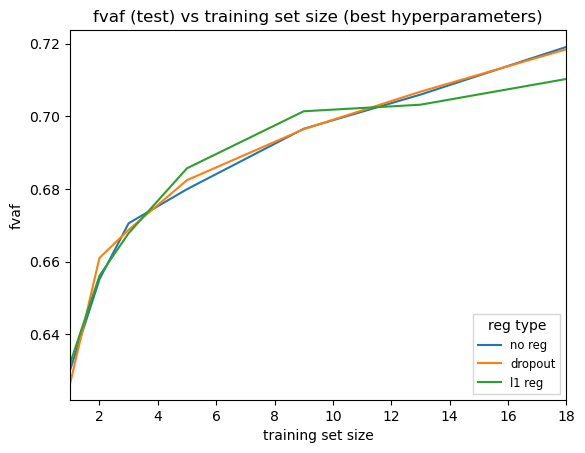

In [30]:
plt.figure()
plt.plot(tss_plot_x, mean_noreg_test, label='no reg')
plt.plot(tss_plot_x, mean_dropout_test, label='dropout')
plt.plot(tss_plot_x, mean_lpreg_test, label='l1 reg')
plt.ylabel('fvaf')
plt.xlabel('training set size')
plt.title('fvaf (test) vs training set size (best hyperparameters)')
plt.xlim([1,18])
plt.legend(title="reg type", loc=4, fontsize='small', fancybox=False)

### t-tests

In [31]:
import scipy

In [32]:
best_index_dropout

array([3, 0, 1, 1, 0, 4, 3], dtype=int64)

In [33]:
best_index_lpreg

array([4, 1, 2, 0, 3, 2, 1], dtype=int64)

In [34]:
ttest_noreg_1 = results_array_noreg[:,0,2]
ttest_dropout_1 = results_array_dropout[:,0,3,2] # 3 comes from best_index_dropout[0]
ttest_lpreg_1 = results_array_lpreg[:,0,4,2] # 4 comes from best_index_lpreg[0]
ttest_noreg_18 = results_array_noreg[:,-1,2]
ttest_dropout_18 = results_array_dropout[:,-1,3,2] # 3 comes from best_index_dropout[-1]
ttest_lpreg_18 = results_array_lpreg[:,-1,1,2] # 1 comes from best_index_lpreg[-1]

#### training set size: 1

In [35]:
scipy.stats.ttest_ind(ttest_noreg_1, ttest_dropout_1)

Ttest_indResult(statistic=0.1566590599814948, pvalue=0.8763429288772201)

In [36]:
scipy.stats.ttest_ind(ttest_noreg_1, ttest_dropout_1, equal_var=False)

Ttest_indResult(statistic=0.1566590599814948, pvalue=0.8763449471254665)

In [37]:
scipy.stats.ttest_rel(ttest_noreg_1, ttest_dropout_1)

TtestResult(statistic=1.4067122747280876, pvalue=0.17565937400646262, df=19)

For each of the above tests, since p > 0.05, we cannot reject the null hypothesis that the two samples have identical expected values

In [38]:
scipy.stats.ttest_ind(ttest_noreg_1, ttest_lpreg_1)

Ttest_indResult(statistic=-0.07430861541709988, pvalue=0.9411546248971546)

In [39]:
scipy.stats.ttest_ind(ttest_noreg_1, ttest_lpreg_1, equal_var=False)

Ttest_indResult(statistic=-0.07430861541709988, pvalue=0.9411546290568965)

In [40]:
scipy.stats.ttest_rel(ttest_noreg_1, ttest_lpreg_1)

TtestResult(statistic=-0.8892019023350579, pvalue=0.38501466170021437, df=19)

For each of the above tests, since p > 0.05, we cannot reject the null hypothesis that the two samples have identical expected values

In [41]:
scipy.stats.ttest_ind(ttest_dropout_1, ttest_lpreg_1)

Ttest_indResult(statistic=-0.23250630475894885, pvalue=0.8173925293976805)

In [42]:
scipy.stats.ttest_ind(ttest_dropout_1, ttest_lpreg_1, equal_var=False)

Ttest_indResult(statistic=-0.23250630475894887, pvalue=0.8173959797890546)

In [43]:
scipy.stats.ttest_rel(ttest_dropout_1, ttest_lpreg_1)

TtestResult(statistic=-1.834413344399903, pvalue=0.08230215298851555, df=19)

For each of the above tests, since p > 0.05, we cannot reject the null hypothesis that the two samples have identical expected values

Conclusion:  
There is no significant difference in the performance of the three model types.  
If you chose a larger p value, you could say that there is a difference between dropout and l1 regularization.  

#### training set size: 18

In [44]:
scipy.stats.ttest_ind(ttest_noreg_18, ttest_dropout_18)

Ttest_indResult(statistic=0.03052137112069502, pvalue=0.975810993430215)

In [45]:
scipy.stats.ttest_ind(ttest_noreg_18, ttest_dropout_18, equal_var=False)

Ttest_indResult(statistic=0.03052137112069502, pvalue=0.9758117235828521)

In [46]:
scipy.stats.ttest_rel(ttest_noreg_18, ttest_dropout_18)

TtestResult(statistic=0.17836300860937485, pvalue=0.8603259360085879, df=19)

For each of the above tests, since p > 0.05, we cannot reject the null hypothesis that the two samples have identical expected values

In [47]:
scipy.stats.ttest_ind(ttest_noreg_18, ttest_lpreg_18)

Ttest_indResult(statistic=0.3992379283696763, pvalue=0.6919528864451023)

In [48]:
scipy.stats.ttest_ind(ttest_noreg_18, ttest_lpreg_18, equal_var=False)

Ttest_indResult(statistic=0.3992379283696763, pvalue=0.691953194249691)

For each of the above tests, since p > 0.05, we cannot reject the null hypothesis that the two samples have identical expected values

In [49]:
scipy.stats.ttest_rel(ttest_noreg_18, ttest_lpreg_18)

TtestResult(statistic=2.1639461127173143, pvalue=0.04341593991779293, df=19)

Since p < 0.05, we reject the null hypothesis that the two samples have identical expected values

In [50]:
scipy.stats.ttest_ind(ttest_dropout_18, ttest_lpreg_18)

Ttest_indResult(statistic=0.38204260992112915, pvalue=0.7045580445747648)

In [51]:
scipy.stats.ttest_ind(ttest_dropout_18, ttest_lpreg_18, equal_var=False)

Ttest_indResult(statistic=0.38204260992112915, pvalue=0.7045714169387003)

For each of the above tests, since p > 0.05, we cannot reject the null hypothesis that the two samples have identical expected values

In [52]:
scipy.stats.ttest_rel(ttest_dropout_18, ttest_lpreg_18)

TtestResult(statistic=2.145310744944026, pvalue=0.04506486134199003, df=19)

Since p < 0.05, we reject the null hypothesis that the two samples have identical expected values

Conclusion:  
There is no significant difference in means of the performance of models with no regularization and those with dropout.  
When comparing the performance of l1 regularization and other models:  
Under the assumption of independent samples, there is no significant difference in the means.  
Under the assumption of related samples, there is a significant difference in means.  
Basically, l1 is probably worse than the other two, which are roughly the same

# Reflection
- For training set size 1, which model type do you prefer? Justify your choice.
- For training set size 18, which model type do you prefer? Justify your choice.
- Looking at the test performance curves, can you conclude anything about which model approach is most appropriate in general?

For training set size 1, I prefer l1 regularization, since it performed the best on average. I am a little suprised that the average performances would be so close for the smallest training set sizes (1,2,3), but for sizes 5 and 9, it is apparent that l1 is better.

For training set size 18, I prefer no regularization, since it performed the best on average. Dropout would probably be as good of a choice, based on the t-test.

I think dropout is the most appropriate model approach in general, because it seems to perform slightly better than no regularization for smaller training set sizes, but is not much worse for large ones (unlike l1 regularization), if at all.